In [234]:
using LinearAlgebra
using Random, Distributions
using Plots
using Convex, SCS

# 2.1

In [1]:
n = 1000
m = 200
μ, σ = 0, 1/sqrt(m)
λ = 0.01
k = 5
γ = 1/4

A = rand(Normal(μ, σ), (m, n))
x_ = vcat(ones(k), zeros(n-k))
b = A*x_

LoadError: UndefVarError: Normal not defined

In [442]:
f

OPTIMAL 0.04970127085689846


0.04970127085689846

In [448]:
function lasso(A, b, m, n, λ, γ, α; use_heavy_ball=false, β=0.001, MAX_ITERS=500)
    _f(x) = 1/2*norm(A*x - b)^2 + λ*norm(x, 1)
    ∂(x) = A'*(A*x - b) + λ*sign.(x)
    
    x = zeros(n)
    prev_x = zeros(n)
    
    best = Inf
    bs, fs = [], []

    for i ∈ 1:MAX_ITERS
        ∂x = ∂(x)
        params = Dict(
            "γ"=>γ,
            "∂"=>∂x,
            "k"=>i,
            "f(x)"=>_f(x)
        )
        Δx = -α(params).*∂x
        if use_heavy_ball
            Δx += β.*(x - prev_x)
        end
        prev_x = deepcopy(x)
        
        x += Δx
        f = _f(x)
        push!(fs, f)
        best = min(best, f)
        push!(bs, best)
    end
    return fs, bs
end

lasso (generic function with 5 methods)

constant_step
0.24179437893614059
polyak
0.049912595695774456
1/k
0.14786139773561155
1/sqrt(k)
0.06634432882308315
constant_step_len
0.15726531948212447


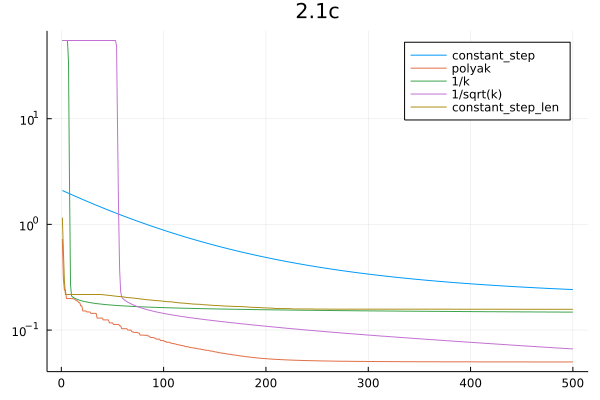

In [449]:
steps = Dict(
    "constant_step"=> params -> 1e-3,
    "constant_step_len" => params -> params["γ"]/norm(params["∂"]),
    "1/sqrt(k)" => params -> 1/sqrt(params["k"]),
    "1/k" => params -> 1/params["k"],
    "polyak" => params -> (params["f(x)"]-f✳)/(norm(params["∂"])^2)
)
p = plot(title="2.1c")
for (key, value) in steps
    println(key)
    fs, bs = lasso(A, b, m, n, λ, γ, value)
    plot!(1:length(bs), bs, label=key, yaxis=:log)
    println(last(bs))
end
p

constant_step
0.21137712547533472
polyak
0.049890406520521506
1/k
0.13928079025498113
1/sqrt(k)
0.052053881818801113
constant_step_len
0.11898968190883011


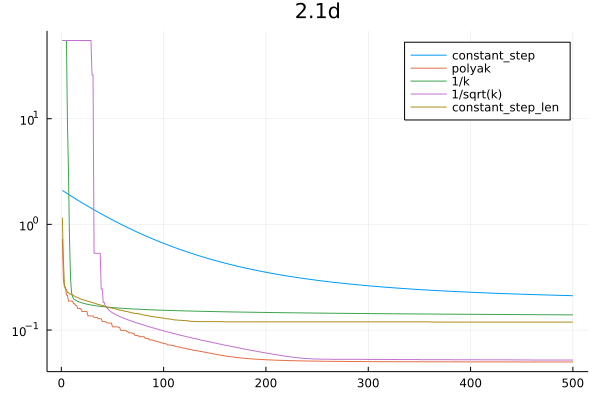

In [465]:
steps = Dict(
    "constant_step"=> params -> 1e-3,
    "constant_step_len" => params -> params["γ"]/norm(params["∂"]),
    "1/sqrt(k)" => params -> 1/sqrt(params["k"]),
    "1/k" => params -> 1/params["k"],
    "polyak" => params -> (params["f(x)"]-f✳)/(norm(params["∂"])^2)
)
betas = Dict(
    "constant_step"=>0.3,
    "constant_step_len"=>0.3,
    "1/sqrt(k)"=>0.5,
    "1/k"=>0.2,
    "polyak"=>0.05
)
p = plot(title="2.1d")
for (key, value) in steps
    println(key)
    beta = betas[key]
    fs, bs = lasso(A, b, m, n, λ, γ, value, use_heavy_ball=true, β=beta)
    plot!(1:length(bs), bs, label=key, yaxis=:log)
    println(last(bs))
end
p

# 2.2

In [626]:
function subgradient_constrained(A, x, y, m, n, α, MAX_ITER=5000)
    # x_ is the ground truth
    rs = []
    
    best = Inf
    bs = []
    
    fs = [
        (x_) -> norm(A*x_ - y)^2,
        (x_) -> x_.-1,
        (x_) -> -x_.-1,
    ]
    
    gs = [
        (x_) -> 2A'*(A*x_ - y),
        (x_) -> ones(n),
        (x_) -> -ones(n)
    ]
    
    x_ = zeros(n)
    for i = 1:MAX_ITER
        feasible = true
        gx_ = zeros(n)
        for (f,g) in zip(fs[2:end], gs[2:end])
            if all(collect(f(x_) .> 0))
                feasible = false
                gx_ = g(x_)
                break
            end
        end
            
        if feasible
            gx_ = gs[1](x_)
        end
        
        params = Dict(
            "k"=>i
        )
        x_ -= α(params).*gx_
        fx_ = fs[1](x_)
        
        if feasible
            best = min(best, fx_)
        end
        
        push!(bs, best)
        push!(rs, norm(x_-x))
    end 
    return rs,x_
end

subgradient_constrained (generic function with 2 methods)

In [651]:
rand([-1, 1])

1

best = 6.336693881396982
diff = 0.00021216469154733796
best = 4.55607473741461
diff = 0.1269054692505918
best = 4.963698763643288
diff = 0.4245144649688664


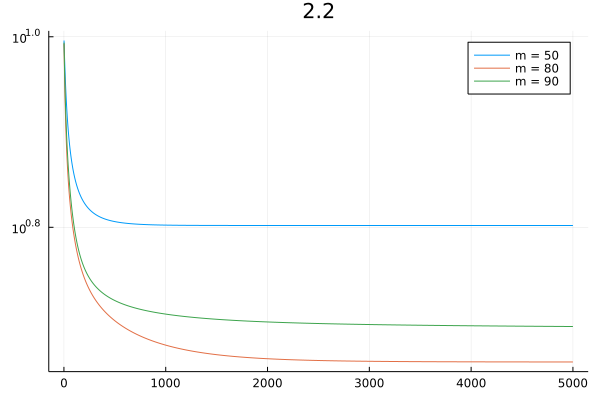

In [652]:
n = 100
α(params) = 0.0001
xs_ = Dict()
p = plot(title="2.2")
for m ∈ [50, 80, 90]
    A = rand(Normal(0, 1), (m, n))
    x = rand([-1, 1], n)
    y = A*x
    rs, x_ = subgradient_constrained(A, x, y, m, n, α)
    xs_[50] = x_
    diff = norm(A*x_-y)
    println("best = $(rs[end])")
    println("diff = $(diff)")
    plot!(1:length(rs), rs, label="m = $(m)", yaxis=:log)
end
p

In [629]:
A*xs_[50] - y

90-element Vector{Float64}:
  0.006490414049866722
  0.027952105632368607
 -0.04882970782402385
  0.019366550415404804
  0.011741867411721785
  0.03144046938966749
  0.015479187310917908
  0.01936654396591564
  0.004619768485218501
 -0.03620027444479801
  0.0015147912699724486
  0.023035745912632244
 -0.0003239946581679032
  ⋮
  0.007456742642671266
  0.011002064080793517
 -0.03772046695158937
  0.0291353171633979
 -0.023971857093348703
 -0.02854181975139447
 -0.05834446473959054
 -0.0665138022869165
  0.011253052194072133
 -0.048403008181068685
 -0.003909831376221362
 -0.014346029894908519

Since the subgradient method for constrained optimization did not seem to be converging, I implemented the alternating method of projections.

diff = 2.88956738002398e-14
7.852805362603076
diff = 4.5437428652248627e-14
1.0292791379448681e-14
diff = 8.329307197227955e-14
1.1361764456651623e-14


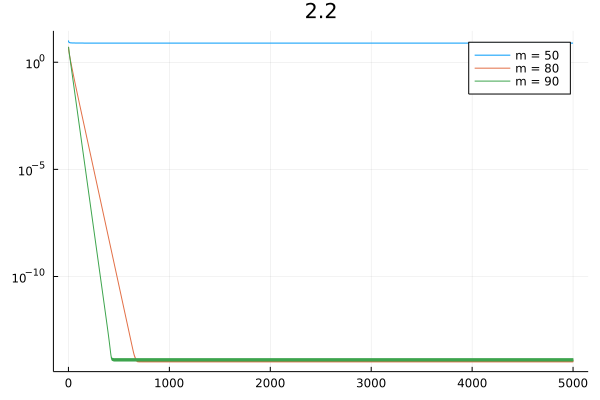

In [653]:
n = 100

p = plot(title="2.2")
for m ∈ [50, 80, 90]
    A = rand(Normal(0, 1), (m, n))
    x = rand([-1, 1], n)
    y = A*x
    
    rs = []
    x_ = ones(n)
    v = A'*inv(A*A')
    
    for i ∈ 1:5000
        if i%2 == 0
            x_ = clamp.(x_, -1, 1)
        else
            x_ = (I - v*A)*x_ + v*y
        end
        r = norm(x_ - x)
        push!(rs, r)
    end
    
    plot!(1:length(rs), rs, label="m = $(m)", yaxis=:log)
    diff = norm(A*x_-y)
    xs_[m] = x_
    println("diff = $(diff)")
    println("$(rs[end])")
end
p

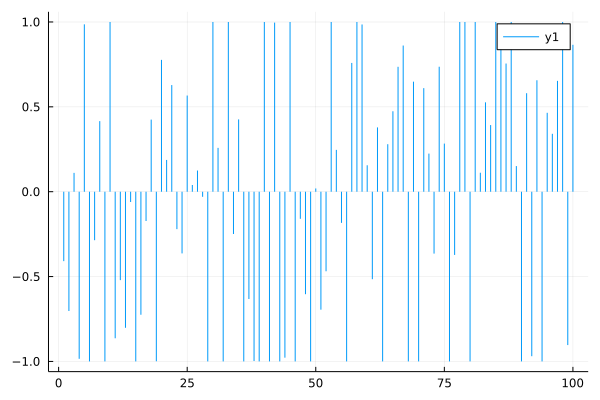

In [654]:
plot(xs_[50], line=:stem)

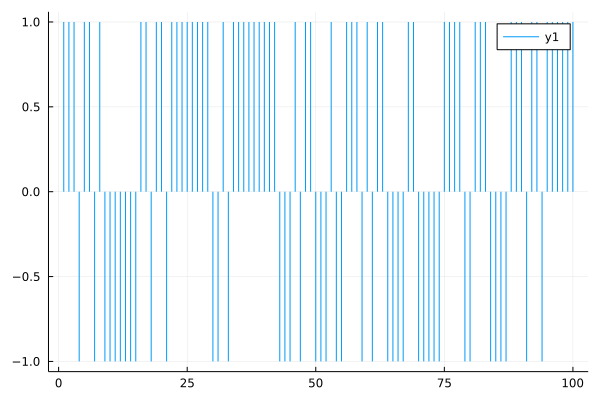

In [655]:
plot(xs_[80], line=:stem)

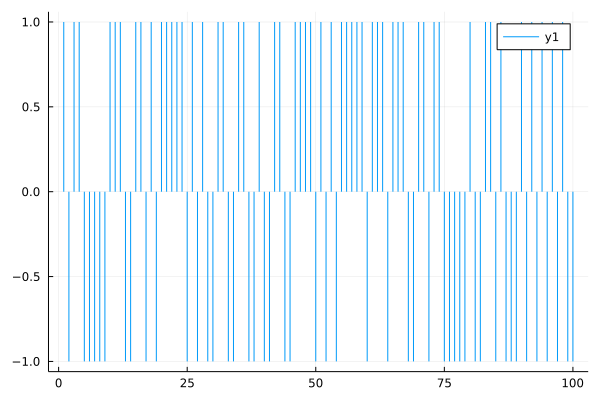

In [656]:
plot(xs_[90], line=:stem)

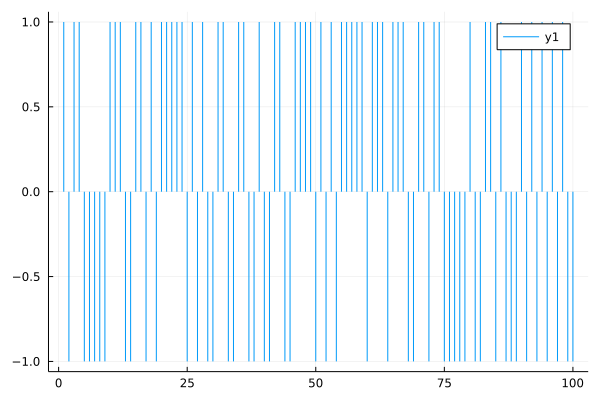

In [657]:
plot(x, line=:stem)

In [624]:
norm(A*xs_[50]-y)

85.04320532974114

# 2.3

In [248]:
x = collect(-2:6)

9-element Vector{Int64}:
 -2
 -1
  0
  1
  2
  3
  4
  5
  6

In [291]:
fx = -2x.*collect(x .<= 0) + (-1/2 .* x).*(collect(x .> 0) .& collect(x .< 4)) + (x.-6).*collect(x .>= 4)

9-element Vector{Float64}:
  4.0
  2.0
  0.0
 -0.5
 -1.0
 -1.5
 -2.0
 -1.0
  0.0

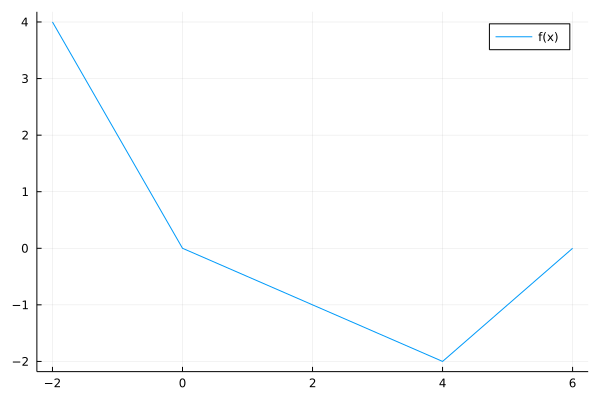

In [293]:
plot(x, fx, label="f(x)")

# 2.4

In [595]:
n = 2
y = [7/4, 0]
x = [0, 4]
Σ = diagm([1, 0.5])

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  0.5

In [596]:
z_(λ, x) = inv(I + λ*Σ)*x

function g_(λ)
    v = z_(λ, x)
    return norm(v-x)^2 + λ*(v'*Σ*v - 1)
end

function proj_E(x)
    lo, hi = 0, 1e3
    while hi-lo > 1e-4
        mid = (lo+hi)/2
#         println("mid = $(mid)")
        if g_(mid) > g_(hi)
            hi = mid
        else 
            lo = mid
        end
    end
    
    println("lo = $(lo), hi = $(hi), g_(lo) = $(g_(lo))")
    return z_(lo, x)
end

function proj_B(x)
    return clamp.(x, y.-1, y.+1)
end

dist_E(x) = norm(proj_E(x)-x)
dist_B(x) = norm(proj_B(x)-x)

f(x) = max(dist_E(x), dist_B(x))

f (generic function with 1 method)

The distance between $x$ and the projection of $x$ on $\mathcal{E}$ is the optimal value for the primal problem. It should be equivalent to the optimal value of the dual problem.

In [597]:
norm(proj_E(x)-x)

lo = 3.6544203758239746, hi = 3.65447998046875, g_(lo) = 6.68629045338513


2.585177707302276

In [586]:
norm(proj_E(x)-x)

2.585177707302276

In [587]:
fs = []
for i = 1:300
    if i % 2 == 0
        x = proj_B(x)
    else
        x = proj_E(x)
    end
    
    fx = f(x)
    push!(fs, fx)
end

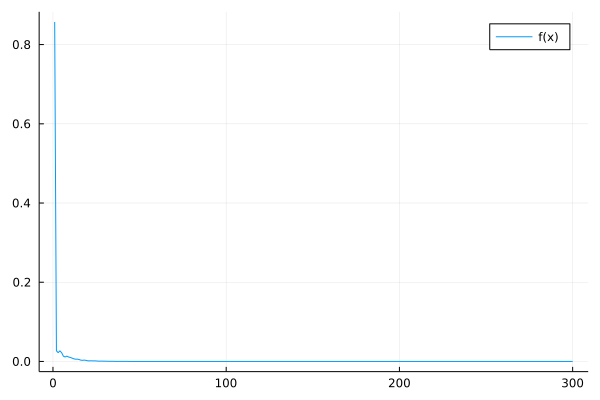

In [588]:
plot(1:length(fs), fs, label="f(x)")